## Working with Keras on IMDB Dataset
    A dataset of movie reviews labeled by whether the movie review is positive or negative

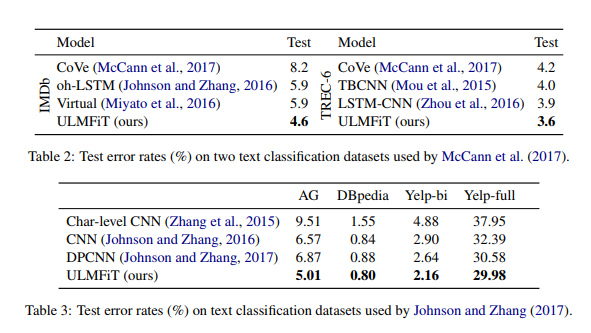

In [1]:
!pip install git+https://github.com/netbrainml/nbml.git
from nbml.tools import *
from IPython.display import clear_output
clear_output()

In [2]:
from keras.datasets import imdb
import numpy as np

old = np.load
np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=1000) #This gets the most common 1000 words

np.load = old
del(old)

shapes(X_train, y_train, X_test, y_test)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

17465344/17464789 [==============================] - 2s 0us/step
arg_0: (25000,)
arg_1: (25000,)
arg_2: (25000,)
arg_3: (25000,)


For NLP (Natural Language Processing), we need to create a vocabulary and map the words into indexes. We can get this from keras. However, we need to assign a couple of key tokens, such as the start of the review, or unknown words. Usually this is common practice.

In [3]:
dictv = imdb.get_word_index()
dictv = {k:(v+3) for k,v in dictv.items()}
dictv["<PAD>"] = 0
dictv["<START>"] = 1
dictv["<UNK>"] = 2
dictv["<UNUSED>"] = 3
dictv

1646592/1641221 [==============================] - 1s 1us/step


{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

We need a way to decipher reviews, so we reverse the dictionary

In [4]:
reverse_word_index = dict([(value, key) for (key, value) in dictv.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
decode_review(X_train[0]), y_train[0]

("<START> this film was just brilliant casting <UNK> <UNK> story direction <UNK> really <UNK> the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same <UNK> <UNK> as myself so i loved the fact there was a real <UNK> with this film the <UNK> <UNK> throughout the film were great it was just brilliant so much that i <UNK> the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the <UNK> <UNK> was amazing really <UNK> at the end it was so sad and you know what they say if you <UNK> at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of <UNK> and paul they were just brilliant children are often left out of the <UNK> <UNK> i think because the stars that play them all <UNK> up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they have done don't 

We also need to pad our sentences so that they are the same length with the pad token.

In [5]:
from keras.preprocessing import sequence

pad_ = max([len(x) for x in X_train])
X_train_pd = sequence.pad_sequences(X_train, value=dictv["<PAD>"], maxlen=pad_, padding='post')
X_test_pd = sequence.pad_sequences(X_test, value=dictv["<PAD>"], maxlen=pad_, padding='post')

shapes(X_train_pd, X_test_pd)

arg_0: (25000, 2494)
arg_1: (25000, 2494)


Each sequence is too long. For now, we can slice the sentences in smaller sequences.

In [6]:
from tqdm import tqdm

def sliceton(X,Y,n):
    out = []
    ys = np.array([])
    for i,review in enumerate(tqdm(X)):
        for idx in range(0, len(review),n):
            if idx+n>len(review)-1:
                out.append(np.array(sequence.pad_sequences(np.array(review[idx: idx+n])[None,:],
                                                           value=dictv["<PAD>"], maxlen=n,
                                                           padding='post')).squeeze())
                ys = np.append(ys,Y[i])
                break    
            out.append(review[idx: idx+n])
            ys = np.append(ys,Y[i])
    return np.array(out), ys

X_train_pds, y_train_pds = sliceton(X_train, y_train, 128)
X_test_pds, y_test_pds = sliceton(X_test, y_test, 128)

shapes(X_train_pds, y_train_pds, X_test_pds, y_test_pds)

100%|██████████| 25000/25000 [00:02<00:00, 12340.60it/s]


arg_0: (59324, 128)
arg_1: (59324,)
arg_2: (57755, 128)
arg_3: (57755,)


## Recurrent Network

In [7]:
from tensorflow import keras
rnn_model = keras.Sequential([
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(1, activation='sigmoid')])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.fit(X_train_pds[::,None].astype(float), y_train_pds, validation_data=(X_test_pds[::,None].astype(float), y_test_pds), epochs=3, batch_size=2048)

Train on 59324 samples, validate on 57755 samples
Epoch 1/3
59324/59324 [==============================] - 1s 15us/sample - loss: 0.8330 - acc: 0.5004 - val_loss: 0.8049 - val_acc: 0.5014
Epoch 2/3
59324/59324 [==============================] - 0s 4us/sample - loss: 0.7803 - acc: 0.5041 - val_loss: 0.7695 - val_acc: 0.5008
Epoch 3/3
59324/59324 [==============================] - 0s 5us/sample - loss: 0.7490 - acc: 0.5078 - val_loss: 0.7493 - val_acc: 0.4988


#### What is Embeddings?
    Learns matrix to map and encode words as real-valued vectors where the similarity between words
    in terms of meaning translates to closeness in the vector space.
*So now we have a vector to represent a word, which its value is learnable*

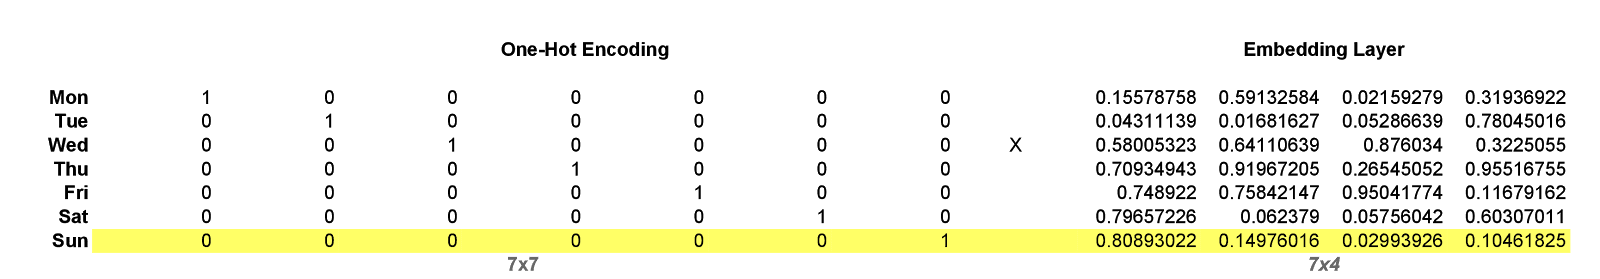

In [8]:
evl = 500
rnnE_model = keras.Sequential([
    keras.layers.Embedding(1000, evl,input_length = 128),
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(1, activation='sigmoid')])

rnnE_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnnE_model.fit(X_train_pds, y_train_pds, validation_data=(X_test_pds, y_test_pds), epochs=5, batch_size=2048)

Train on 59324 samples, validate on 57755 samples
Epoch 1/5
59324/59324 [==============================] - 5s 88us/sample - loss: 0.6836 - acc: 0.5478 - val_loss: 0.6583 - val_acc: 0.6002
Epoch 2/5
59324/59324 [==============================] - 5s 81us/sample - loss: 0.5899 - acc: 0.7015 - val_loss: 0.5568 - val_acc: 0.7288
Epoch 3/5
59324/59324 [==============================] - 5s 79us/sample - loss: 0.5118 - acc: 0.7570 - val_loss: 0.5060 - val_acc: 0.7636
Epoch 4/5
59324/59324 [==============================] - 5s 80us/sample - loss: 0.4772 - acc: 0.7775 - val_loss: 0.5044 - val_acc: 0.7493
Epoch 5/5
59324/59324 [==============================] - 5s 82us/sample - loss: 0.4552 - acc: 0.7892 - val_loss: 0.4946 - val_acc: 0.7703


## LSTM and GRU

In [9]:
from tensorflow import keras
evl = 500

lstm_model = keras.Sequential([
    keras.layers.Embedding(1000, evl,input_length = 128),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.fit(X_train_pds, y_train_pds, validation_data=(X_test_pds, y_test_pds), epochs=5, batch_size=2048)

Train on 59324 samples, validate on 57755 samples
Epoch 1/5
59324/59324 [==============================] - 10s 169us/sample - loss: 0.6792 - acc: 0.5521 - val_loss: 0.6116 - val_acc: 0.6809
Epoch 2/5
59324/59324 [==============================] - 9s 157us/sample - loss: 0.5374 - acc: 0.7436 - val_loss: 0.4972 - val_acc: 0.7691
Epoch 3/5
59324/59324 [==============================] - 9s 156us/sample - loss: 0.4743 - acc: 0.7791 - val_loss: 0.4638 - val_acc: 0.7734
Epoch 4/5
59324/59324 [==============================] - 9s 154us/sample - loss: 0.4529 - acc: 0.7874 - val_loss: 0.4578 - val_acc: 0.7822
Epoch 5/5
59324/59324 [==============================] - 9s 156us/sample - loss: 0.4487 - acc: 0.7862 - val_loss: 0.4478 - val_acc: 0.7883


In [10]:
gru_model = keras.Sequential([
    keras.layers.Embedding(1000, evl,input_length = 128),
    keras.layers.GRU(64),
    keras.layers.Dense(1, activation='sigmoid')])

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

gru_model.fit(X_train_pds, y_train_pds, validation_data=(X_test_pds, y_test_pds), epochs=5, batch_size=2048)

Train on 59324 samples, validate on 57755 samples
Epoch 1/5
59324/59324 [==============================] - 9s 152us/sample - loss: 0.6891 - acc: 0.5278 - val_loss: 0.6812 - val_acc: 0.5541
Epoch 2/5
59324/59324 [==============================] - 8s 140us/sample - loss: 0.5885 - acc: 0.6744 - val_loss: 0.4948 - val_acc: 0.7708
Epoch 3/5
59324/59324 [==============================] - 9s 151us/sample - loss: 0.4738 - acc: 0.7790 - val_loss: 0.4694 - val_acc: 0.7790
Epoch 4/5
59324/59324 [==============================] - 8s 140us/sample - loss: 0.4558 - acc: 0.7893 - val_loss: 0.4578 - val_acc: 0.7856
Epoch 5/5
59324/59324 [==============================] - 8s 139us/sample - loss: 0.4561 - acc: 0.7877 - val_loss: 0.4608 - val_acc: 0.7834


In [11]:
titanic_review = """James Cameron's 'Titanic' shares a similar motto to Marmite,
            "you either love it or hate it", I for one love this film, yes 
            I know it's got a drawn out romance story, but there's just
            something about the 3-hour fill of the film that makes its such a
            spectacularly emotional and beautiful movie. I saw this a lot when 
            I was growing up, this was one of the films of my childhood, it is 
            truly a powerfully resonant and visually stunning movie of epic proportions. 
            Personally I favour the British original 'A Night to Remember', but this is a 
            pretty close contender. Winner of 11 Oscars, James Cameron's romantic-disaster
            epic is a triumph of cinema that boasts perfect chemistry between Kate and Leo as 
            the lovers bound for tragedy. Many people disregard this film nowadays solely
            because it's become the most popular film ever made alongside Cameron's other epic 
            'Avatar', and whilst 'Titanic' is definitely not one of my favourite films, it's 
            just so powerfully amazing and no doubt at all it has once brought a tear to everyone's 
            eyes. The main aspect I love in this film is James Horner's haunting score that was a key
            ingredient in the film's success, it is simply perfect, too bad Celine Dion had to close
            this on her awful pop version. Nonetheless, 'Titanic' is a modern classic and a 
            beautifully spectacular film that will live on."""

gotti_review = """I'd rather wake up next to a severed horse head than ever watch 'Gotti' again. 
            The worst movie of the year so far, the long-awaited biopic about the Gambino crime boss' rise from
            made man to top dog took four directors, 44 producers and eight years to make. It shows. The finished
            product belongs in a cement bucket at the bottom of the river."""

In [12]:
def getSent(review, model):
    review_ar = []
    for word in review.split(" "):
        val = dictv.get(word)
        review_ar.append(val) if val is not None else None
    review_ar = sequence.pad_sequences(np.array(review_ar)[None,::], maxlen=128, padding='post')
    print(review_ar,review_ar.shape)
    print(model.predict(review_ar))

In [13]:
getSent(titanic_review,rnnE_model), getSent(gotti_review,rnnE_model)

[[  108     7    61    12     9   371     6 10354 19724     5  2009  1380
     20     7  1711  5260     4   204     8    21    14     9     6   184
    491     7  1502  1711     9     6  3823     7   438    15  6091   404
   1175   200     5    17     4  1846  2725    18    84  8112    14    22
   2889    88    45   413     4    91  1063    22   126    93  4648    85
   1711     5  1864     9   407    24    31     7    61  1640    45    43
     38 10354   480     5    57   824    33    32    12    47   280   839
      6  3325     8  4468   293  1251   119    11    14    22     9  2299
    603    15    16     6 10918    11     4   598    12     9   331    99
     78    69     8    14    23    41   373  1719     9     6   682   356
      5     6  1293  2093    22    15    80   412]] (1, 128)
[[0.50999177]]
[[  247  3290    56   375     8     6  6429  1817   419    74   126   106
    249    20     7     4   291    38     4  7421    44     4   823 23097
   2200    93   132     8   350   91

(None, None)

In [14]:
getSent(titanic_review,lstm_model), getSent(gotti_review,lstm_model)

[[  108     7    61    12     9   371     6 10354 19724     5  2009  1380
     20     7  1711  5260     4   204     8    21    14     9     6   184
    491     7  1502  1711     9     6  3823     7   438    15  6091   404
   1175   200     5    17     4  1846  2725    18    84  8112    14    22
   2889    88    45   413     4    91  1063    22   126    93  4648    85
   1711     5  1864     9   407    24    31     7    61  1640    45    43
     38 10354   480     5    57   824    33    32    12    47   280   839
      6  3325     8  4468   293  1251   119    11    14    22     9  2299
    603    15    16     6 10918    11     4   598    12     9   331    99
     78    69     8    14    23    41   373  1719     9     6   682   356
      5     6  1293  2093    22    15    80   412]] (1, 128)
[[0.8580209]]
[[  247  3290    56   375     8     6  6429  1817   419    74   126   106
    249    20     7     4   291    38     4  7421    44     4   823 23097
   2200    93   132     8   350   912

(None, None)

In [15]:
getSent(titanic_review,gru_model), getSent(gotti_review,gru_model)

[[  108     7    61    12     9   371     6 10354 19724     5  2009  1380
     20     7  1711  5260     4   204     8    21    14     9     6   184
    491     7  1502  1711     9     6  3823     7   438    15  6091   404
   1175   200     5    17     4  1846  2725    18    84  8112    14    22
   2889    88    45   413     4    91  1063    22   126    93  4648    85
   1711     5  1864     9   407    24    31     7    61  1640    45    43
     38 10354   480     5    57   824    33    32    12    47   280   839
      6  3325     8  4468   293  1251   119    11    14    22     9  2299
    603    15    16     6 10918    11     4   598    12     9   331    99
     78    69     8    14    23    41   373  1719     9     6   682   356
      5     6  1293  2093    22    15    80   412]] (1, 128)
[[0.5956694]]
[[  247  3290    56   375     8     6  6429  1817   419    74   126   106
    249    20     7     4   291    38     4  7421    44     4   823 23097
   2200    93   132     8   350   912

(None, None)